In [1]:
from pulp import *
import numpy as np
import matplotlib.pyplot as plt
import itertools
from IPython.display import Image, display_png
%matplotlib inline

# ビンパッキング問題

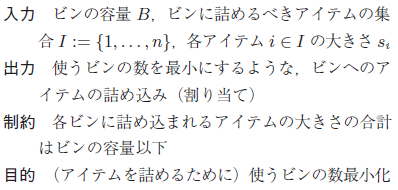

In [2]:
display_png(Image('pictures/bin_packing.PNG'))

# 整数計画問題として普通に定式化
* 変数や制約式の個数が入力の多項式サイズの定式化を目指す
* 整数計画問題としての定式化において「登場するものの個数は全て固定する」のは基本的なテクニックの一つである  
  ここではビンの個数は最大でもアイテムと同じ個数で十分

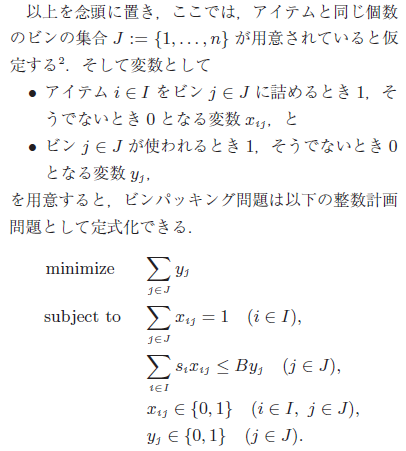

In [3]:
display_png(Image('pictures/formula1.PNG'))

In [2]:
def create_toy_problem(B, n_items, seed):
    np.random.seed(seed)
    s = np.random.randint(low=1, high=B, size=n_items)
    return s

In [5]:
prob = LpProblem(name='formula1', sense=LpMinimize)

# 定数
B = 15
n = 10
s = create_toy_problem(B, n, 77)

# 変数
x = [[LpVariable(f'x{i},{j}', lowBound=0, cat='Binary') for j in range(n)] for i in range(n)]
y = [LpVariable(f'y{j}', lowBound=0, cat='Binary') for j in range(n)]

# 目的関数
prob += lpSum(y[j] for j in range(n))

# 制約式
for i in range(n):
    prob += lpSum(x[i][j] for j in range(n)) == 1
for j in range(n):
    prob += lpSum(s[i] * x[i][j] for i in range(n)) <= B * y[j]
for j in range(n-1):
    prob += y[j] >= y[j+1]
    
# 求解
prob.solve()
print('Status: ', LpStatus[prob.status])
print(f'Optimal value = {value(prob.objective)}')

Status:  Optimal
Optimal value = 5.0


In [6]:
n_bins = int(value(prob.objective))
for j in range(n_bins):
    print(f'bin{j}: ')
    total = 0
    for i in range(n):
        if value(x[i][j]) == 1:
            total += s[i]
            print(f'{x[i][j]}: {s[i]}')
    print(f'Total: {total}')
    print('')

bin0: 
x5,0: 9
x9,0: 6
Total: 15

bin1: 
x1,1: 5
x7,1: 10
Total: 15

bin2: 
x0,2: 8
x4,2: 6
x6,2: 1
Total: 15

bin3: 
x3,3: 12
Total: 12

bin4: 
x2,4: 5
x8,4: 8
Total: 13



# トリッキーな定式化
* 変数の個数が入力の指数サイズになるような定式化を試してみる

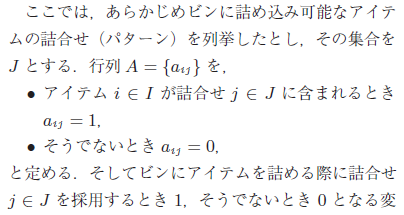

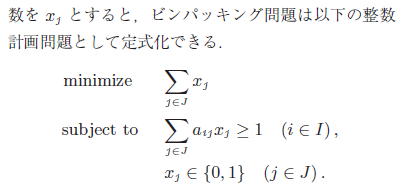

In [7]:
display_png(Image('pictures/formula2-1.PNG'))
display_png(Image('pictures/formula2-2.PNG'))

In [8]:
prob = LpProblem(name='formula2', sense=LpMinimize)

# 定数
B = 15
n = 10
s = create_toy_problem(B, n, 77)

# ビンに詰め込み可能な全パターン
a = dict()
all_pattern = []
# ビンに詰め込める組合せを列挙
for i in range(1, n):
    for pattern, weight in zip(itertools.combinations(range(n), i), itertools.combinations(s, i)):
        if sum(weight) <= B:
            all_pattern.append(pattern)
# アイテムiが組合せjに属していれば1，そうでなければ0
for j, pattern in enumerate(all_pattern):
    for i in range(n):
        if i in pattern:
            a[i, j] = 1
        else:
            a[i, j] = 0

len_j = len(all_pattern)

# 変数
x = [LpVariable(f'x{j}', lowBound=0, cat='Binary') for j in range(len_j)]
# 連続緩和
#x = [LpVariable(f'x{j}', lowBound=0, upBound=1, cat='Continuous') for j in range(len_j)]

# 目的関数
prob += lpSum(x[j] for j in range(len_j))

# 制約式
for i in range(n):
    prob += lpSum(a[i, j] * x[j] for j in range(len_j)) >= 1
    
# 求解
prob.solve()
print('Status: ', LpStatus[prob.status])
print(f'Optimal value = {value(prob.objective)}')

Status:  Optimal
Optimal value = 5.0


In [9]:
bin_count = 0
for j in range(len_j):
    if value(x[j]) == 1:
        print(f'bin{bin_count}')
        bin_count += 1
        total = 0
        for i in all_pattern[j]:
            print(f'{i}: {s[i]}')
            total += s[i]
        print('Total: ', total)
        print('')

bin0
0: 8
9: 6
Total:  14

bin1
1: 5
7: 10
Total:  15

bin2
2: 5
5: 9
Total:  14

bin3
3: 12
6: 1
Total:  13

bin4
4: 6
8: 8
Total:  14



連続緩和しても最適値は同じ -> 代わりに連続緩和問題を解いてもそれなりに役に立ちそう

# 線形緩和問題の双対を解く

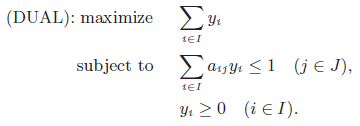

In [10]:
display_png(Image('pictures/formula3.PNG'))

In [11]:
# 定数
B = 15
n = 10
s = create_toy_problem(B, n, 77)

# ビンに詰め込み可能な全パターン
a = dict()
all_pattern = []
# ビンに詰め込める組合せを列挙
for i in range(1, n):
    for pattern, weight in zip(itertools.combinations(range(n), i), itertools.combinations(s, i)):
        if sum(weight) <= B:
            all_pattern.append(pattern)
# アイテムiが組合せjに属していれば1，そうでなければ0
for j, pattern in enumerate(all_pattern):
    for i in range(n):
        if i in pattern:
            a[i, j] = 1
        else:
            a[i, j] = 0

len_j = len(all_pattern)

prob = LpProblem(name='subprob', sense=LpMaximize)
# 変数
y = [LpVariable(f'y{i}', lowBound=0, cat='Continuous') for i in range(n)]
# 目的関数
prob += lpSum(y[i] for i in range(n))
# 制約式
for j in range(len_j):
    prob += lpSum(a[i, j] * y[i] for i in range(n)) <= 1
# 求解
prob.solve()
print(f'Optimal value = {value(prob.objective)}')

Optimal value = 5.0000000000050004


# ビンパッキング問題の構造を利用して列生成法
* あまり速くならない．たぶんコードがまずい？

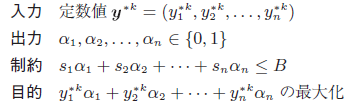

In [12]:
display_png(Image('pictures/formula4.PNG'))

In [3]:
# 定数
B = 15
n = 10
s = create_toy_problem(B, n, 77)

# アイテムを一つだけ入れるパターンのみを最初の制約式として用いる
a = dict()
for i, j in itertools.product(range(n), range(n)):
    if i == j:
        a[i, j] = 1
    else:
        a[i, j] = 0
len_j = n

# ビンパッキング問題の部分問題
prob = LpProblem(name='subprob', sense=LpMaximize)
# 変数
y = [LpVariable(f'y{i}', lowBound=0, cat='Continuous') for i in range(n)]
# 目的関数
prob += lpSum(y[i] for i in range(n))
# 制約式
for j in range(len_j):
    prob += lpSum(a[i, j] * y[i] for i in range(n)) <= 1
# 求解
prob.solve()
y_star = [value(v) for v in prob.variables()]
opt_val = value(prob.objective)
print(f'Optimal value = {opt_val}')

# 部分問題の最適解が全体の最適解に一致するか確認（ナップサック問題）
def solve_ks(y_star):
    prob = LpProblem(name='subprob', sense=LpMaximize)
    # 変数
    z = [LpVariable(f'z{i}', lowBound=0, cat='Binary') for i in range(n)]
    # 目的関数
    prob += lpSum(y_star[i] * z[i] for i in range(n))
    # 制約式
    prob += lpSum(s[i] * z[i] for i in range(n)) <= B
    # 求解
    prob.solve()
    print('Optimal value of kp: ', value(prob.objective))
    if value(prob.objective) > 1:
        a_new = [value(v) for v in prob.variables()]
        return a_new
    else:
        a_new = 0
        return a_new

# ナップサック問題の最適値が1より大きければ，制約（ナップサック問題の最適解）を追加して解き直し
while True:
    a_new = solve_ks(y_star)
    if a_new != 0:
        len_j += 1
        for i in range(n):
            a[i, len_j-1] = a_new[i]
        prob += lpSum(a[i, len_j-1] * y[i] for i in range(n)) <= 1
    else:
        break
    # 求解
    prob.solve()
    y_star = [value(v) for v in prob.variables()]
    if opt_val != value(prob.objective):
        opt_val = value(prob.objective)
        print(f'Optimal value = {opt_val}')

Optimal value = 10.0
Optimal value of kp:  3.0
Optimal value = 8.0
Optimal value of kp:  3.0
Optimal value = 7.0
Optimal value of kp:  2.0
Optimal value of kp:  2.0
Optimal value of kp:  2.0
Optimal value of kp:  2.0
Optimal value of kp:  1.5
Optimal value = 6.666666660000001
Optimal value of kp:  2.0
Optimal value = 6.5
Optimal value of kp:  1.5
Optimal value = 6.0
Optimal value of kp:  2.0
Optimal value of kp:  2.0
Optimal value of kp:  1.5
Optimal value of kp:  1.5
Optimal value = 5.666666660000001
Optimal value of kp:  1.66666666
Optimal value = 5.5
Optimal value of kp:  1.5
Optimal value of kp:  1.5
Optimal value = 5.0
Optimal value of kp:  2.0
Optimal value of kp:  1.0
